In [2]:
import csv
import matplotlib
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import scipy.stats as stats
import scipy.stats as ss
from matplotlib import style
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6, 4)


from sklearn.decomposition import RandomizedPCA, PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25


# look for systematic cnv noise in 53 ffpe pogs

In [3]:
f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/pog_cnv_ffpe/pog_ffpe_segs_files.txt'
df1 = pd.read_csv(f1, sep='\t', header=None, comment='#', encoding='utf-8')
df1.columns = ['patient', 'seg_path']
assert df1.shape[0] == 58
df1.head(2)

,patient,seg_path
0,POG001,/projects/POG/POG_data/POG001/wgs/arch1_t_A105...
1,POG002,/projects/POG/POG_data/POG002/wgs/arch1_t_A105...


In [4]:
df2 = pd.DataFrame()
for idx, row in df1.iterrows():
    pat = row['patient']
    seg_file = row['seg_path']
#     print(pat, seg_file)
    # cnv_files, some rows have 10 columns instead of 9, problems from the APLcnv pipeline
    cnv = pd.read_csv(seg_file, sep='\t',  error_bad_lines=False, warn_bad_lines=True)
    cnv.columns = ['chr', 'start', 'end', 'cn']
    cnv = cnv[cnv.cn != 2]
    cnv['patient'] = pat
    if df2.empty:
        df2 = cnv
    else: df2 = pd.concat([df2,cnv])

In [5]:
df2.shape

(354984, 5)

In [6]:
df2.patient.nunique()

58

In [7]:
assert df2.patient.nunique() == 58 # some patient has no cnvs?

In [8]:
df2.head(2)

,chr,start,end,cn,patient
1,1,2052400,2249710,3,POG001
3,1,2314324,2350477,3,POG001


In [9]:
df2['seg_length'] = (df2.end - df2.start)

In [10]:
df2.head(2)

,chr,start,end,cn,patient,seg_length
1,1,2052400,2249710,3,POG001,197310
3,1,2314324,2350477,3,POG001,36153


In [18]:
# f2 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/pog_cnv/segments_less_than_1mb.txt'

# df2.to_csv(f2, index=False, sep='\t')

In [13]:
# focus on focal events here, ~75% cnv , 1Mb
df3 = df2[df2.seg_length <1e6]

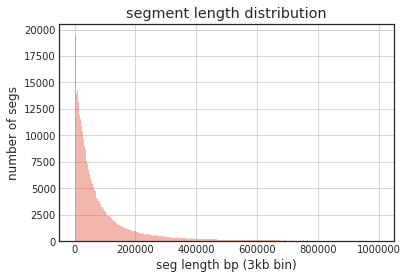

In [17]:
# amps segment length distribution
with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    fig = plt.figure(facecolor='w')
    sns.distplot(df3.seg_length, kde=False, bins=333)
    plt.title('segment length distribution')
    plt.xlabel('seg length bp (3kb bin)')
    plt.ylabel('number of segs')
#     plt.xlim(0, 100000)
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/pog_cnv_ffpe/ffpe_segs_1mb_length_distribution.png'
plt.savefig(of, dpi=200, bbox_inches='tight')

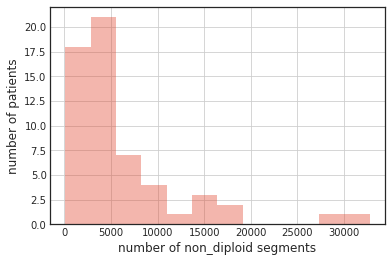

In [18]:
# segments per patient
segments = df2.groupby('patient').count().sort_values('cn', ascending=False)['cn']

# distribution of number of segments
with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    fig = plt.figure(facecolor='w')
    sns.distplot(segments, kde=False)
    plt.xlabel('number of non_diploid segments')
    plt.ylabel('number of patients')
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/pog_cnv_ffpe/segs_distribution.png'
# plt.savefig(of, dpi=500)

In [19]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/pog_cnv_ffpe/amps.txt'
of2 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/pog_cnv_ffpe/dels.txt'
df2[df2.cn >2].to_csv(of, index=False, header=None, sep='\t')
df2[df2.cn <2].to_csv(of2, index=False, header=None, sep='\t')

In [11]:
patients = df2.patient.value_counts().index.tolist()

In [12]:
len(patients)

58

find systematic cnv noise

generate regions to review for all patients:

 while read a b;do /home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools intersect -a $b  -b amps_noise_to_review.txt -wa -wb|awk '$4>2'|awk '{print $1"\t"$2"\t"$3"\t"$4"\t"$5"\t"$6"\t"$7"\t"$8"\t"$9"\t"($3-$2)/1000}'|sort -k10nr>$a.amp.to.review;done < segs_file.tmp 
 
 while read a b;do /home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools intersect -a $b  -b dels_noise_to_review.txt -wa -wb|awk '$4<2'|awk '{print $1"\t"$2"\t"$3"\t"$4"\t"$5"\t"$6"\t"$7"\t"$8"\t"$9"\t"($3-$2)/1000}'|sort -k10nr>$a.del.to.review;done < segs_file.tmp 
 
 use this command to see window size of a region:
 
 grep -w -C 50 38306472 
/projects/somatic/NCI_SAIC_HIV_Cervical/HTMCP-03-06-02213/hg19a/GSH/A54387_A54514/cnv/tc_60/18647/w200/w200_cna.txt


bin cnv into 1kb bins

sort -k1n -k2n -k3n amps.txt > amps.txt.sorted 

/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools intersect -a ../bin_segs/chr_bins.txt -b amps.txt.sorted -wa -wb > amps_bins_1kb.txt

sort -k1n -k2n -k3n dels.txt > dels.txt.sorted

/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools intersect -a ../bin_segs/chr_bins.txt -b dels.txt.sorted -wa -wb > dels_bins_1kb.txt


figure out how many patients having deletions in each bin

/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools intersect -a chr_bins.txt -b dels.txt.sorted -wa -wb > dels_bins_1kb.txt

In [13]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/pog_cnv_ffpe/dels_bins_1kb.txt'
df = pd.read_csv(f, sep='\t', header=None)
df.columns = ['bin_chr', 'bin_start', 'bin_end', 'chr', 'start', 'end', 'cn', 'patient', 'length']
df = df[['bin_chr', 'bin_start', 'bin_end','patient']]
occurrence = df.groupby(['bin_chr', 'bin_start', 'bin_end']).nunique()['patient']#.sort_values(ascending=False)
recur_dels = occurrence.reset_index().sort_values(['bin_chr', 'bin_start', 'bin_end'])

In [14]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/pog_cnv_ffpe/dels_bins_1kb_patients.txt'
# recur_dels.to_csv(f, index=False, sep='\t')
recur_dels = pd.read_csv(f, sep='\t')

In [15]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/pog_cnv_ffpe/amps_bins_1kb.txt'
df = pd.read_csv(f, sep='\t', header=None)
df.columns = ['bin_chr', 'bin_start', 'bin_end', 'chr', 'start', 'end', 'cn', 'patient', 'length']
df.head(2)

occurrence = df.groupby(['bin_chr', 'bin_start', 'bin_end']).nunique()['patient']#.sort_values(ascending=False)

occurrence.head()

type(occurrence.reset_index())

recur_amps = occurrence.reset_index().sort_values(['bin_chr', 'bin_start', 'bin_end'])

recur_amps.head()

,bin_chr,bin_start,bin_end,patient
0,1,39001,40000,1
1,1,40001,41000,1
2,1,41001,42000,1
3,1,42001,43000,1
4,1,43001,44000,1


In [16]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/pog_cnv_ffpe/amps_bins_1kb_patients.txt'
# recur_amps.to_csv(f, index=False, sep='\t')
recur_amps = pd.read_csv(f, sep='\t')

In [17]:
df2.head(2)

,chr,start,end,cn,patient,seg_length
1,1,2052400,2249710,3,POG001,197310
3,1,2314324,2350477,3,POG001,36153


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


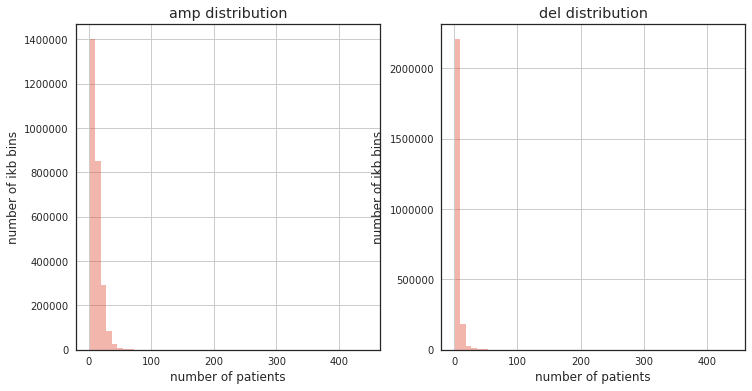

In [77]:
# distribution of number of patients for each bin
with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    fig = plt.figure(facecolor='w', figsize=(12, 6))
    ax1 = fig.add_subplot(121)
    sns.distplot(recur_amps.patient, kde=False)
    ax1.set_xlabel('number of patients')
    ax1.set_ylabel('number of ikb bins')
    ax1.set_title('amp distribution')
    
    ax2 = fig.add_subplot(122)
    sns.distplot(recur_dels.patient, kde=False)
    ax2.set_xlabel('number of patients')
    ax2.set_ylabel('number of ikb bins')
    ax2.set_title('del distribution')
#     plt.ylim(0,350000)
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/pog_cnv/bin_distribution.png'
plt.savefig(of, dpi=500)

In [18]:
# plot chromosomes
f3 = '/home/szong/projects/resource/hg19_cytoband_ucsc.txt'
df3 = pd.read_csv(f3, header=None, sep='\t')
df3.columns = ['chr', 'start', 'end', 'cytoband', 'comments']
df3.head(2)

,chr,start,end,cytoband,comments
0,1,0,2300000,p36.33,gneg
1,1,2300000,5400000,p36.32,gpos25


processing chr 1 and the chr_offset is 0
plotting amp aggregation


/projects/da_workspace/software/miniconda/envs/dlpy3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/projects/da_workspace/software/miniconda/envs/dlpy3/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


plotting del aggregation
processing chr 2 and the chr_offset is 249250621
plotting amp aggregation
plotting del aggregation
processing chr 3 and the chr_offset is 492449994
plotting amp aggregation
plotting del aggregation
processing chr 4 and the chr_offset is 690472424
plotting amp aggregation
plotting del aggregation
processing chr 5 and the chr_offset is 881626700
plotting amp aggregation
plotting del aggregation
processing chr 6 and the chr_offset is 1062541960
plotting amp aggregation
plotting del aggregation
processing chr 7 and the chr_offset is 1233657027
plotting amp aggregation
plotting del aggregation
processing chr 8 and the chr_offset is 1392795690
plotting amp aggregation
plotting del aggregation
processing chr 9 and the chr_offset is 1539159712
plotting amp aggregation
plotting del aggregation
processing chr 10 and the chr_offset is 1680373143
plotting amp aggregation
plotting del aggregation
processing chr 11 and the chr_offset is 1815907890
plotting amp aggregation
pl

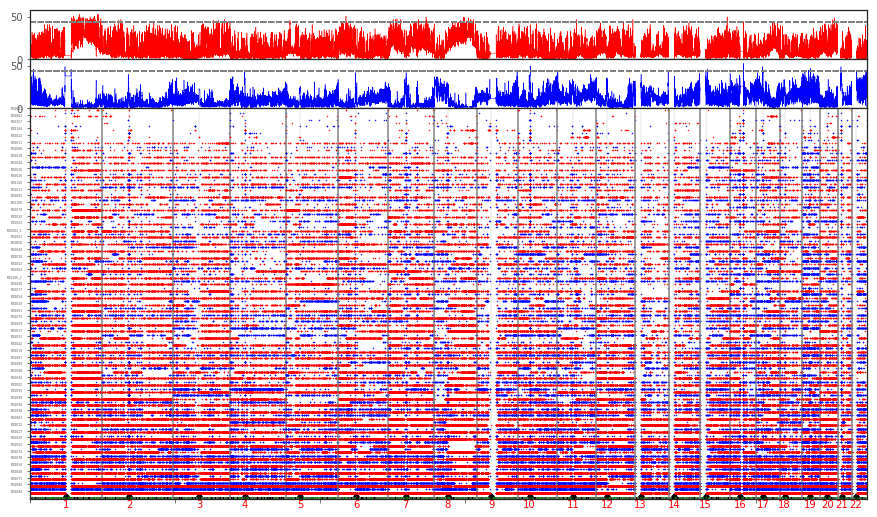

In [20]:
# new code 20180606 this is only to plot segments <1mb, not showing the cn or seg length, only +
df_segs = df2.copy()
df_cytoband = df3.copy()
# fig = plt.figure(figsize=with plt.style.context("seaborn-white"):
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
#     fig = plt.figure(facecolor='w', figsize=(15,9))
fig = plt.figure(figsize=(15, 9), facecolor='white')
gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,8],
                       wspace=0.05, # horizontal space
                       hspace=0.0  # vertical space
                      )

ax0 = fig.add_subplot(gs[0], facecolor='white')
ax1 = fig.add_subplot(gs[1], facecolor='white')
ax2 = fig.add_subplot(gs[2], facecolor='white')
chr_offset = 0 # chromosome offset
num_patients = len(patients)
#     ylim = 4
ylim = num_patients/10.0+0.1
for chr in np.arange(1,23):
    print('processing chr {0} and the chr_offset is {1}'.format(chr, chr_offset))
    dfchr = df_cytoband[df_cytoband.chr=='{}'.format(chr)]
    clrs = ['-k', '-g']*100

    num_segs = dfchr.shape[0]
    # plot centromere
    acen = dfchr[dfchr.comments=='acen'].reset_index().loc[0, 'end'] + chr_offset
    ax2.plot(acen, 0.1, color='black',marker='D', markersize=4)
    ax2.axvline(x=acen, color='gray', linewidth=0.2)
    ax2.text(acen, -.25, '{}'.format(chr), color='red', horizontalalignment='center')

    clrs = clrs[:num_segs]
    i = 0 # color index
    for idx, row in dfchr.iterrows():
        start = row.start + chr_offset
        end = row.end + chr_offset
        cytoband = row.cytoband
        comment = row.comments
        center = (start + end)/2 + chr_offset
        width = int(end - start)
        ax2.plot((start, end), (0.05,0.05), clrs[i], linewidth=3, solid_capstyle='butt')        
        i+=1


    # draw chromosome boundary
    ax2.axvline(x=chr_offset, color='gray')


    # plot amp aggregate results
    amps = recur_amps.query('bin_chr == {0}'.format(chr))
    print('plotting amp aggregation')
    amps['x'] = amps.bin_start + chr_offset
    ax0.plot(amps.x, amps.patient, color='red', linewidth=.5, solid_capstyle='butt')
    ax0.axhline(y=0.75*num_patients, color='gray', linestyle='dashed')

    # plot del aggregate results
    dels = recur_dels.query('bin_chr == {0}'.format(chr))
    print('plotting del aggregation')
    dels['x'] = dels.bin_start + chr_offset
    ax1.plot(dels.x, dels.patient, color='blue', linewidth=.5, solid_capstyle='butt')
    ax1.axhline(y=0.75*num_patients, color='gray', linestyle='dashed')


    # plot cnvs
    j = 0 # row offset
    yticks = []
    cnvy_coords = []
    for patient in patients: 
#             print('plotting patient {0}, cnvy_coords is {1}'.format(patient, 0.2+j))
        # plot amplification
        amps = df_segs.query('chr == {0} & patient == "{1}" & cn > 2'.format(chr, patient))
        m=0 #test label offset to be deleted
        for idx, row in amps.iterrows():
            start = row.start + chr_offset
            end = row.end + chr_offset
            length = end - start
            cn = row.cn
#                 if chr == 7 or chr ==14:
#                     print('plotting amps line {0}:{1}-{2}, cn {3}, length {4}'.format(chr, row.start, row.end, cn, row.end-row.start))


#                 it looks like can not see anything <150000 on a 3 billion scale, so magnfiy anything to 150000
            if length < 1e6:
                pos = 0.5*(start + end)
#                 end = start + 150000
#                 print('{0} {1} has a amp < 150kb {2}: {3}: {4}'.format(patient, chr, pos, end-start, cn))
                ax2.plot(pos, 0.2+j, color='red', marker='.', markersize=1)# solid_capstyle='butt')
#                 ax2.text(start, 0.2+m, str(row.start))
#                 m+=0.2
        # plot deletion
        dels = df_segs.query('chr == {0} & patient == "{1}" & cn < 2'.format(chr, patient))
        for idx, row in dels.iterrows():
            start = row.start + chr_offset
            end = row.end + chr_offset
            length = end - start
            cn = row.cn
            if length < 1e6:
                pos = 0.5*(start + end)
                del_w = 2 - cn
                ax2.plot(pos, 0.3+j, color='blue', marker='.', markersize=1)
        yticks.append(0.25+j)
        j+=0.2
    chr_offset+=max(dfchr.end)
ax0.set_xlim(0, chr_offset)
ax0.set_ylim(0, num_patients)
ax1.set_xlim(0, chr_offset)
ax1.set_ylim(0, num_patients)
ax2.set_xlim(0, chr_offset)
ax2.set_ylim(0, ylim)
ax0.set_xticklabels('')
ax1.set_xticklabels('')
ax2.set_xticklabels('')
ax2.set_yticks(yticks)
# ax2.set_yticklabels([i.split('-')[3] for i in patients], fontsize=3)
ax2.set_yticklabels([i for i in patients], fontsize=3)
#     plt.tight_layout()
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/pog_cnv_ffpe/cnv_pog_ffpe_patients_test.png'
plt.savefig(of, dpi=800)
plt.show()#(15, 9), facecolor='white')


In [195]:
df3.head(2)

,chr,start,end,cytoband,comments
0,chr1,0,2300000,p36.33,gneg
1,chr1,2300000,5400000,p36.32,gpos25


# review cna zoomed-in plots
You can run Matlab from your command line with this command:
/gsc/software/linux-x86_64-centos6/matlab-r2016a/bin/matlab

 From there if you just open a .fig file through the menu it will give 
you a window with the zoom tools at the top.

# below are outdated

In [197]:
# patients

In [ ]:
# plot cytoband hg19
df_segs = df2.copy()
df_cytoband = df3.copy()

In [255]:
patients = ['HTMCP-03-06-02071', 'HTMCP-03-06-02330', 'HTMCP-03-06-02441']

In [ ]:
pat

processing chr 1 and the chr_offset is 0
plotting amp aggregation


/home/szong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


plotting del aggregation


/home/szong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


processing chr 2 and the chr_offset is 249250621
plotting amp aggregation
plotting del aggregation
processing chr 3 and the chr_offset is 492449994
plotting amp aggregation
plotting del aggregation
processing chr 4 and the chr_offset is 690472424
plotting amp aggregation
plotting del aggregation
processing chr 5 and the chr_offset is 881626700
plotting amp aggregation
plotting del aggregation
processing chr 6 and the chr_offset is 1062541960
plotting amp aggregation
plotting del aggregation
processing chr 7 and the chr_offset is 1233657027
plotting amp aggregation
plotting del aggregation
processing chr 8 and the chr_offset is 1392795690
plotting amp aggregation
plotting del aggregation
processing chr 9 and the chr_offset is 1539159712
plotting amp aggregation
plotting del aggregation
processing chr 10 and the chr_offset is 1680373143
plotting amp aggregation
plotting del aggregation
processing chr 11 and the chr_offset is 1815907890
plotting amp aggregation
plotting del aggregation
pr

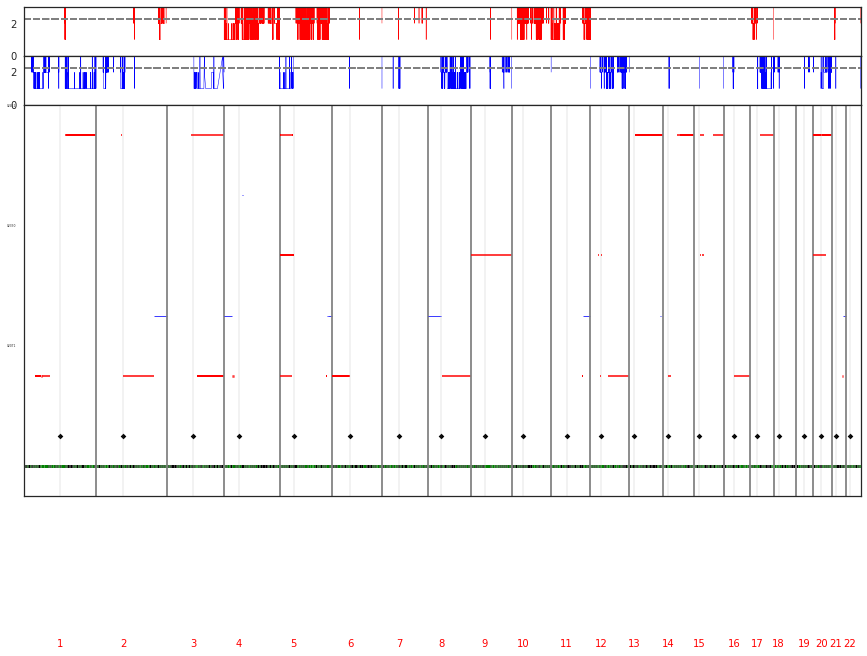

In [256]:
with plt.style.context("seaborn-white"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
#     fig = plt.figure(facecolor='w', figsize=(15,9))
    fig = plt.figure(figsize=(15, 9), facecolor='white')
    gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,8],
                           wspace=0.05, # horizontal space
                           hspace=0.0  # vertical space
                          )
    
    ax0 = fig.add_subplot(gs[0], facecolor='white')
    ax1 = fig.add_subplot(gs[1], facecolor='white')
    ax2 = fig.add_subplot(gs[2], facecolor='white')
    chr_offset = 0 # chromosome offset
    num_patients = len(patients)
#     ylim = 4
    ylim = num_patients/10.0+0.1
    for chr in np.arange(1,23):
        print('processing chr {0} and the chr_offset is {1}'.format(chr, chr_offset))
        dfchr = df_cytoband[df_cytoband.chr=='chr{}'.format(chr)]
        clrs = ['-k', '-g']*100
        
        num_segs = dfchr.shape[0]
        # plot centromere
        acen = dfchr[dfchr.comments=='acen'].reset_index().loc[0, 'end'] + chr_offset
        ax2.plot(acen, 0.1, color='black',marker='D', markersize=4)
        ax2.axvline(x=acen, color='gray', linewidth=0.2)
        ax2.text(acen, -.25, '{}'.format(chr), color='red', horizontalalignment='center')
        
        clrs = clrs[:num_segs]
        i = 0 # color index
        for idx, row in dfchr.iterrows():
            start = row.start + chr_offset
            end = row.end + chr_offset
            cytoband = row.cytoband
            comment = row.comments
            center = (start + end)/2 + chr_offset
            width = int(end - start)
            ax2.plot((start, end), (0.05,0.05), clrs[i], linewidth=3, solid_capstyle='butt')        
            i+=1

        
        # draw chromosome boundary
        ax2.axvline(x=chr_offset, color='gray')
        
        
        # plot amp aggregate results
        amps = recur_amps.query('bin_chr == {0}'.format(chr))
        print('plotting amp aggregation')
        amps['x'] = amps.bin_start + chr_offset
        ax0.plot(amps.x, amps.patient, color='red', linewidth=.5, solid_capstyle='butt')
        ax0.axhline(y=0.75*num_patients, color='gray', linestyle='dashed')

        # plot del aggregate results
        dels = recur_dels.query('bin_chr == {0}'.format(chr))
        print('plotting del aggregation')
        dels['x'] = dels.bin_start + chr_offset
        ax1.plot(dels.x, dels.patient, color='blue', linewidth=.5, solid_capstyle='butt')
        ax1.axhline(y=0.75*num_patients, color='gray', linestyle='dashed')
 
       
        # plot cnvs
        j = 0 # row offset
        yticks = []
        cnvy_coords = []
        for patient in patients: 
#             print('plotting patient {0}, cnvy_coords is {1}'.format(patient, 0.2+j))
            # plot amplification
            amps = df_segs.query('chr == {0} & patient == "{1}" & cn > 2'.format(chr, patient))
            m=0 #test label offset to be deleted
            for idx, row in amps.iterrows():
                start = row.start + chr_offset
                end = row.end + chr_offset
                length = end - start
                cn = row.cn
#                 if chr == 7 or chr ==14:
#                     print('plotting amps line {0}:{1}-{2}, cn {3}, length {4}'.format(chr, row.start, row.end, cn, row.end-row.start))
                    

#                 it looks like can not see anything <150000 on a 3 billion scale, so magnfiy anything to 150000
                if length < 150000:
                    end = start + 150000
                ax2.plot((start, end), (0.2+j, 0.2+j), color='red', marker='_', linewidth=cn*0.5, solid_capstyle='butt')
#                 ax2.text(start, 0.2+m, str(row.start))
#                 m+=0.2
            # plot deletion
            dels = df_segs.query('chr == {0} & patient == "{1}" & cn < 2'.format(chr, patient))
            for idx, row in dels.iterrows():
                start = row.start + chr_offset
                end = row.end + chr_offset
                length = end - start
                cn = row.cn
                if length < 150000:
                    end = start + 150000
                del_w = 2 - cn
                ax2.plot((start, end), (0.3+j, 0.3+j), color='blue', marker='_', linewidth=del_w*0.75, solid_capstyle='butt')
            yticks.append(0.25+j)
            j+=0.2
        chr_offset+=max(dfchr.end)
    ax0.set_xlim(0, chr_offset)
    ax0.set_ylim(0, num_patients)
    ax1.set_xlim(0, chr_offset)
    ax1.set_ylim(0, num_patients)
    ax2.set_xlim(0, chr_offset)
    ax2.set_ylim(0, ylim)
    ax0.set_xticklabels('')
    ax1.set_xticklabels('')
    ax2.set_xticklabels('')
    ax2.set_yticks(yticks)
    ax2.set_yticklabels([i.split('-')[3] for i in patients], fontsize=3)
#     plt.tight_layout()
    of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/cnv_123_patients.png'
    plt.savefig(of, dpi=800)
    plt.show()

sanity check: because of resolution, bands less than 100kb in length may not show on the plot.

    while read a b;do echo -ne $a"\t";/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools intersect -a $b -b a.tmp ;done < Cervical_124_patients_adjusted/cnv_files_for_acen_removal.txt |awk '$5>2'

 these are 3 examples of peaks in 7q14.1, we should see them in the plot
 while read a b;do echo -ne $a"\t";/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools intersect -a $b -b 7q14.1_peak_coords.txt -wa -wb;done < cnv_files_for_acen_removal.txt|grep "02441\|02330\|02071"
 
HTMCP-03-06-02071	7	38294085	38374669	4	7	38311127	38338695

HTMCP-03-06-02330	7	38309671	38338696	4	7	38311127	38338695

HTMCP-03-06-02441	7	38292804	38368824	4	7	38311127	38338695


clean up by removing GISTIC wide peaks after review

In [ ]:
# peak region to remove: my scipts identified
# 6	58776001	58780001	4000
# 7	38294001	38371001	77000
# 14	22406001	22971001	565000

# GISTIC wide peaks
# chr14:22779419-22934657	
# chr7:38311127-38338695	
# chr7:142421419-142476036
# chr4:68264255-68264791



In [75]:
f3 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/peaks_to_remove.txt'
df3 = pd.read_csv(f3, comment="#", sep='\t', header=None)
df3.columns= ['chr', 'start', 'end', 'length']
df3

,chr,start,end,length
0,6,58776001,58780001,4000
1,14,22779419,22934657,155238
2,7,38311127,38338695,27568
3,7,142421419,142476036,54617
4,4,68264255,68264791,536


In [ ]:
# rules to clean up
# overlap 10% of the interval to be removed
# if cn>2 and orginal segment < 50mb, change the cn to 2

In [76]:
df1.head(2)

,patient,seg_path
0,HTMCP-03-06-02001,/projects/somatic/NCI_SAIC_HIV_Cervical/HTMCP-...
1,HTMCP-03-06-02002,/projects/somatic/NCI_SAIC_HIV_Cervical/HTMCP-...


In [91]:
def overlap_intervals(a, b):
    return max(0, min(a[1], b[1]) - max(a[0], b[0]))


In [176]:
# shorted chromosome 21 ~48Mb
def mask_cnv(df_segs, df_masks, of):
    with open(of, 'w') as writer:
        for i, row in df_segs.iterrows():
            chrm = row[0]
            start = row[1]
            end = row[2]
            cn = row[3]
            length = end - start
            chrms = df_masks.chr.unique()
            if chrm in chrms and cn >2 and length < 5000000:
                for j, m_row in df_masks.iterrows():
                    m_chrm = m_row[0]
                    m_start = m_row[1]
                    m_end = m_row[2]
                    m_length = m_end - m_start
                    if chrm == m_chrm:
                        overlap = overlap_intervals([start, end], [m_start, m_end])
                        if overlap/min(length, m_length)*1.0 > 0.1:
                            print('ovelap', overlap, "change cn to 2")
                            cn = 2
            writer.write('\t'.join([str(i) for i in [chrm, start, end, cn]]))
            writer.write('\n')


In [86]:
# for idx, row in df1.iterrows():
#     patient = row.patient
#     seg_file = row.seg_path
#     dftmp = pd.read_csv(seg_file, sep='\t', header=None)
#     of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/Cervical_124_patients_adjusted/w200_clean/{}/w200_segs_cleaned.txt'.format(patient)
#     mask_cnv(dftmp, df3, of)

look at skin normal and ffpe samples

In [4]:
f = '/projects/trans_scratch/validations/workspace/szong/POG/pog_skin_normals_and_ffpe.tsv'
df = pd.read_csv(f, sep='\t')
df.head(2)

,POG,name,control_anatomic_site,is_ffpe,tumour_content,data_path
0,POG001,A10504_A10501,Blood-Peripheral,NaN,13,/projects/somatic/POG/POG001/hg19a/GSH/A10504_...
1,POG001,A10504_A10501,Blood-Peripheral,NaN,23,/projects/somatic/POG/POG001/hg19a/GSH/A10504_...


In [21]:
skins = [i for i in df.control_anatomic_site.unique() if 'Skin' in i]


In [24]:
for i in skins:
    print(i)

Skin-Head and Neck
Skin
Skin-Chest
Skin-Back
Skin-Arm


In [23]:
df[df.control_anatomic_site.isin(skins)].name.nunique()

10

In [16]:
df[df.control_anatomic_site == 'Skin'].name.nunique()

5

In [12]:
df[df.is_ffpe == 't'].name.nunique()

53

In [13]:
df.name.nunique()

862